In [128]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from surprise.dataset import Dataset,DatasetAutoFolds
from surprise import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('ratings_Electronics.csv')

In [3]:
data.columns = ['userId','productId','ratings','timestamp']

In [4]:
data.drop(columns='timestamp',inplace=True)

In [5]:
data.head()

,userId,productId,ratings
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000007697CDE898>]],
      dtype=object)

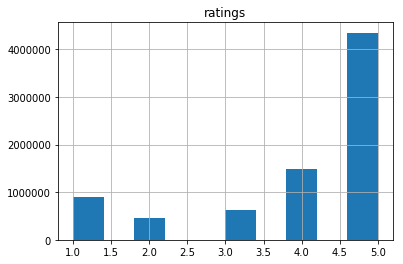

In [201]:
data.hist(column='ratings')

More than 4 lakh people have given very high ratings to the Electronics, i.e., most of them liked the electronics very much.
Also, we can see that there is no average rating for the electronics around 2.5 rating.
The people either liked the electronics or disliked the electronics.

Let's group the data on userids

In [24]:
gr = data.groupby('userId')
groups = gr.groups

In [66]:
#filter_df will contain users who has rated 50 or more items
filter_df = pd.DataFrame()
for each_user in gr.count()[gr.count()['productId']>=50].index:
    filter_df = filter_df.append(data.loc[groups[each_user]])

In [67]:
filter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 66536 to 7811737
Data columns (total 3 columns):
userId       125871 non-null object
productId    125871 non-null object
ratings      125871 non-null float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB


In [71]:
train_data,test_data = train_test_split(filter_df,shuffle=True,test_size = 0.3)

In [80]:
reader = Reader(rating_scale=(train_data['ratings'].min(), train_data['ratings'].max()))
trainset = Dataset.load_from_df(train_data,reader)

Let's build popularity based model

In [188]:
print('Below are the top 5 popular products recommended')
popularity_model = train_data.groupby('productId')['ratings'].mean().sort_values(ascending=False).head(5)
popularity_model

Below are the top 5 popular products recommended


productId
B00LKG1MC8    5.0
B002Q609FW    5.0
B002PY7LME    5.0
B002PY7OF8    5.0
B002PY7OJE    5.0
Name: ratings, dtype: float64

Now, let's build the collaborative filtering model

In [81]:
algo = SVD()
algo.fit(trainset.build_full_trainset())

In [99]:
predicted_ratings = []
for each_index in test_data.index: 
    predicted_ratings.append(algo.predict(test_data.loc[each_index].userId,test_data.loc[each_index].productId).est)

In [102]:
actual_ratings = test_data['ratings'].values

In [130]:
rmse = pow((((actual_ratings-predicted_ratings)**2).sum())/len(predicted_ratings),0.5)

In [131]:
print('rmse of collabrative model {}'.format(rmse))

rmse of collabrative model 0.988254193723947


Let's take a random user to do the top K (K=5) predictions

In [176]:
unique_users=test_data['userId'].unique()

In [177]:
random_user = unique_users[np.random.randint(low=0,high=len(unique_users))]
random_user

'A1QQA7Y92L4F9R'

In [178]:
product_set = test_data['productId'].unique()
user_alrdy_rated = test_data[test_data.userId==random_user].productId.values
user_not_rated = np.setdiff1d(product_set,user_alrdy_rated)

In [179]:
predictions=[]
for each_product in user_not_rated:
    predictions.append(algo.predict(random_user,each_product).est)

In [180]:
user_pred_df = pd.DataFrame({'ProductId':user_not_rated,'predicted_ratings':predictions})
user_pred_df.sort_values(by='predicted_ratings',ascending=False,inplace=True)
print('Following are top 5 recommendations for the user {}'.format(random_user))
print(user_pred_df.head(5))

Following are top 5 recommendations for the user A1QQA7Y92L4F9R
        ProductId  predicted_ratings
15010  B005OA3BSY                5.0
8656   B002BH3Z8E                5.0
6601   B0019EHU8G                5.0
15031  B005ONMDYE                5.0
4208   B000IZDN60                5.0


Let's compare the two models created

In [190]:
print('for the user {} the popularity based model recommends'.format(random_user))
print(popularity_model)

for the user A1QQA7Y92L4F9R the popularity based model recommends
productId
B00LKG1MC8    5.0
B002Q609FW    5.0
B002PY7LME    5.0
B002PY7OF8    5.0
B002PY7OJE    5.0
Name: ratings, dtype: float64


Let's see what model predicts for the same prodcucts for the given user

In [200]:
for product in popularity_model.index:
    print(product,algo.predict(random_user,product).est)

B00LKG1MC8 4.685652180848105
B002Q609FW 4.465946657586414
B002PY7LME 4.60759738814407
B002PY7OF8 4.650847539295998
B002PY7OJE 4.636213874148136
